# Basic System

This notebook provides code for implementing a very simple machine learning system for named entity recognition.
It uses logistic regression and one feature (the token itself).
Links to information about the packages are provided. Your job is to document the code and use it to train a system. You can then use your evaluation code to provide the first basic evaluation of your system.

*Note:* In the next assignment, you can use this as a basis to experiment with more features and more machine learning methods.

### About this Notebook:
- The notebook is structured similarly to the assignment pdf. Each question contains suggestions to help guide you, but remember to follow the requirements in the PDF for your final answers.

In [1]:
from collections import defaultdict, Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import sys
import os

# If you want to include other modules, you can add them here
# Please note the recommendations on using modules in the Programming General Guidelines

#recommended resource for examples: https://scikit-learn.org/stable/modules/feature_extraction.html




## 2.1. Load and inspect the data
**Suggestions:**
 - Download the following files form from canvas ,and place them in the folder "`./data/conll2003`":
   - `conll2003.train.conll`, `conll2003.test.conll`, `conll2003.dev.conll`


In [2]:
def extract_features(inputfile):
    """Helper function to parse a document in CONLL format and build a feature dictionary for each token"""   
    data = []
    with open(inputfile, 'r', encoding='utf8') as infile:
        for line in infile:
            components = line.rstrip('\n').split()
            if len(components) > 0:
                token = components[0]
                feature_dict = {'token':token}
                data.append(feature_dict)
    return data

In [3]:
def extract_features_and_labels(trainingfile):
    """
    Helper function to parse a document in CONLL format and build a feature dictionary for each token.
    This version extracts additional features for hypothesis testing and training.
    """ 
    data = []
    targets = []
    with open(trainingfile, 'r', encoding='utf8') as infile:
        for line in infile:
            components = line.rstrip('\n').split() # just extract more features in this function to avoid more loops down the road
            if len(components) > 0:  
                token = components[0]
                pos_tag = components[1]
                chunk_tag = components[2]
                ner_tag = components[3]

                feature_dict = {
                    'token': token,
                    'pos_tag': pos_tag,
                    'chunk_tag': chunk_tag,
                    'capitalized': token[0].isupper(),
                    'contains_digit': any(char.isdigit() for char in token),
                    'token_length': len(token)
                }
                
                data.append(feature_dict)
                targets.append(ner_tag)
    return data, targets

In [4]:
def extract_features_and_labels_with_downsampling(trainingfile):
    """
    Helper function to parse a document in CONLL format and build a feature dictionary for each token.
    Includes downsampling of "O" tokens that are not adjacent to entity tokens.
    """
    data = []
    targets = []

    # Read the file into memory for context-aware processing
    with open(trainingfile, 'r', encoding='utf8') as infile:
        lines = infile.readlines()

    for i, line in enumerate(lines):
        components = line.rstrip('\n').split()

        if len(components) > 0:  # Non-empty line represents a token
            token = components[0]
            pos_tag = components[1]
            chunk_tag = components[2]
            ner_tag = components[3]

            # Check neighboring tags to decide whether to keep this "O" token
            if ner_tag == "O":
                prev_tag = lines[i - 1].strip().split()[-1] if i > 0 and lines[i - 1].strip() else None
                next_tag = lines[i + 1].strip().split()[-1] if i < len(lines) - 1 and lines[i + 1].strip() else None

                # Skip this "O" token if it is not adjacent to any entity tag
                if (prev_tag is None or prev_tag == "O") and (next_tag is None or next_tag == "O"):
                    continue

            # Create the feature dictionary for the current token
            feature_dict = {
                'token': token,
                'pos_tag': pos_tag,
                'chunk_tag': chunk_tag,
                'capitalized': token[0].isupper(),
                'contains_digit': any(char.isdigit() for char in token),
                'token_length': len(token)
            }

            # Add the current token's features and label
            data.append(feature_dict)
            targets.append(ner_tag)

    return data, targets


In [5]:
def create_dataframe(data, targets):
    """Helper function to turn the datasets into dataframes"""   
    records = []
    for features, target in zip(data, targets):
        record = features.copy()
        record['NER'] = target
        records.append(record)
    
    return pd.DataFrame(records)

In [6]:
data_folder = "../../data/conll2003/"

train_file = data_folder + "conll2003.train.conll"
test_file = data_folder + "conll2003.test.conll"
dev_file = data_folder + "conll2003.dev.conll"

In [7]:
# train_data, train_targets = extract_features_and_labels(train_file)
train_data, train_targets = extract_features_and_labels_with_downsampling(train_file)
test_data, test_targets = extract_features_and_labels(test_file)
dev_data, dev_targets = extract_features_and_labels(dev_file)

# Create dfs for each set
train_df = create_dataframe(train_data, train_targets)
test_df = create_dataframe(test_data, test_targets)
dev_df = create_dataframe(dev_data, dev_targets)

In [8]:
train_df.head()

,token,pos_tag,chunk_tag,capitalized,contains_digit,token_length,NER
0,EU,NNP,B-NP,True,False,2,B-ORG
1,rejects,VBZ,B-VP,False,False,7,O
2,German,JJ,B-NP,True,False,6,B-MISC
3,call,NN,I-NP,False,False,4,O
4,boycott,VB,I-VP,False,False,7,O


## 2.2. Data analysis: feature and label distributions
**Suggestions:**

- Inspect which unique NER labels there are and plot their distribution (tip: look into the `Counter()`)
- Evaluate the samples per class to answer the questions in the pdf

### 2.2.1 NER Label Distribution

Distribution of NER Labels:
O: 34870
B-LOC: 7140
B-PER: 6600
B-ORG: 6321
I-PER: 4528
I-ORG: 3704
B-MISC: 3438
I-LOC: 1157
I-MISC: 1155


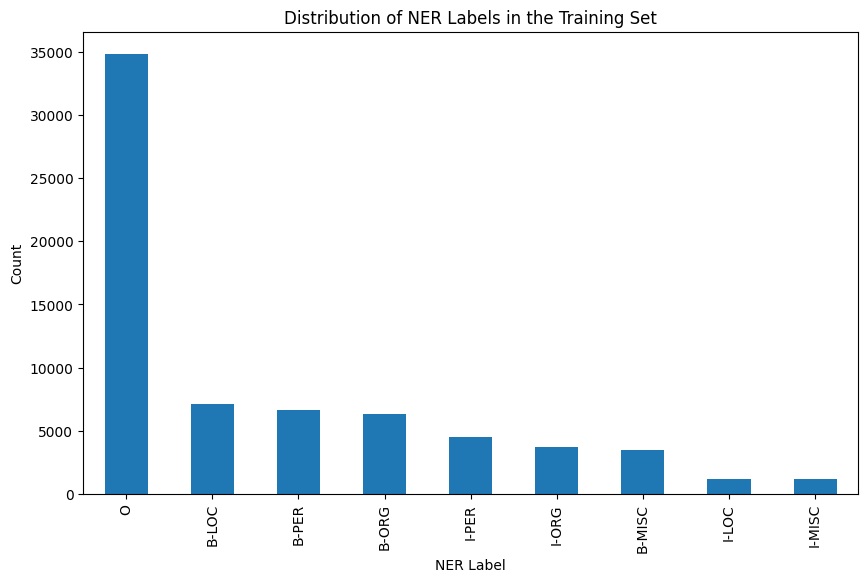

In [9]:
label_counts = train_df['NER'].value_counts()
print("Distribution of NER Labels:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel("NER Label")
plt.ylabel("Count")
plt.title("Distribution of NER Labels in the Training Set")
plt.show()


### 2.2.2 Feature Hypotheses

#### Hypothesis 1: Capitalized words
Capitalized words are more likely to be named entities


Proportion of Capitalized Words by NER Tag:
B-LOC: 1.00
B-MISC: 0.99
B-ORG: 1.00
B-PER: 1.00
I-LOC: 0.96
I-MISC: 0.89
I-ORG: 0.91
I-PER: 0.98
O: 0.06


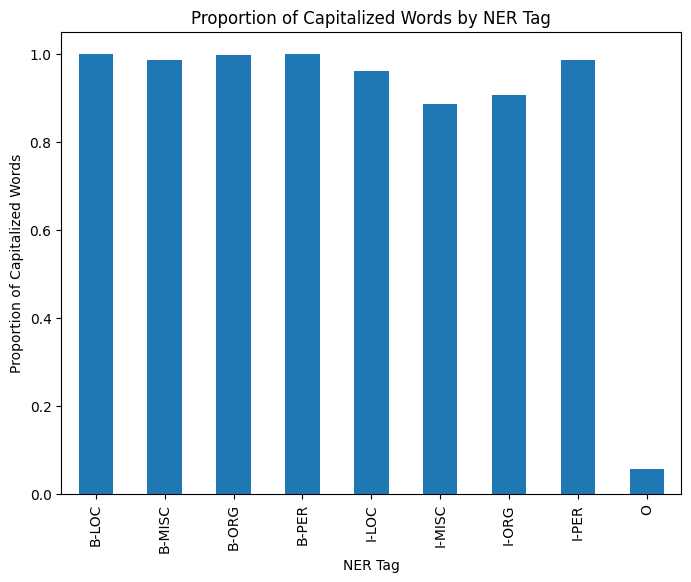

In [10]:
total_counts = train_df['NER'].value_counts()
capitalized_counts = train_df[train_df['capitalized']].groupby('NER').size()
capitalization_ratios = (capitalized_counts / total_counts).fillna(0)  

print("Proportion of Capitalized Words by NER Tag:")
for label, ratio in capitalization_ratios.items():
    print(f"{label}: {ratio:.2f}")

plt.figure(figsize=(8, 6))
capitalization_ratios.plot(kind='bar')
plt.xlabel("NER Tag")
plt.ylabel("Proportion of Capitalized Words")
plt.title("Proportion of Capitalized Words by NER Tag")
plt.show()


#### Hypothesis 2: POS Tags
Specific POS tags, are strongly associated with named entities. Test Case: proper nouns (NNP) 

Proportion of NNP-tagged Tokens by NER Tag:
B-LOC: 0.93
B-MISC: 0.44
B-ORG: 0.84
B-PER: 0.93
I-LOC: 0.90
I-MISC: 0.72
I-ORG: 0.82
I-PER: 0.97
O: 0.04


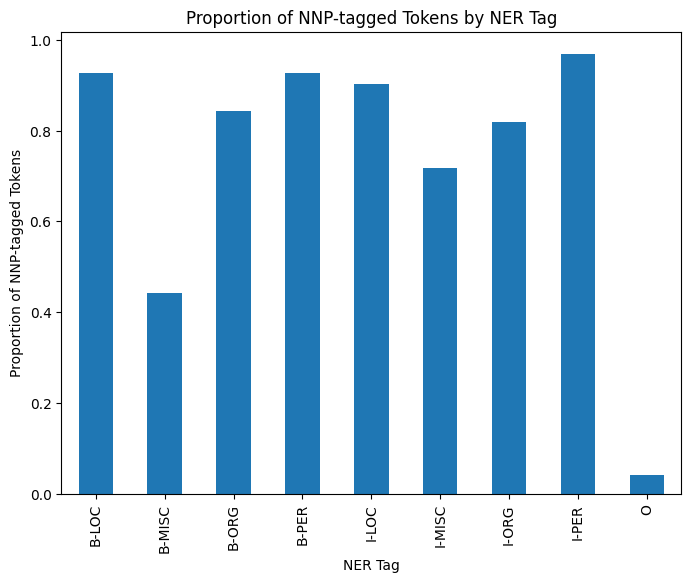

In [11]:
total_counts = train_df['NER'].value_counts()
nnp_counts = train_df[train_df['pos_tag'] == 'NNP'].groupby('NER').size()
nnp_ratios = (nnp_counts / total_counts).fillna(0)  

print("Proportion of NNP-tagged Tokens by NER Tag:")
for label, ratio in nnp_ratios.items():
    print(f"{label}: {ratio:.2f}")

plt.figure(figsize=(8, 6))
nnp_ratios.plot(kind='bar')
plt.xlabel("NER Tag")
plt.ylabel("Proportion of NNP-tagged Tokens")
plt.title("Proportion of NNP-tagged Tokens by NER Tag")
plt.show()


#### Hypothesis 3: Token Length
Tokens with longer lengths tend to appear more frequently in categories such as ORG or LOC.

Average Token Length by NER Tag:
B-LOC: 6.38
B-MISC: 6.78
B-ORG: 6.40
B-PER: 5.76
I-LOC: 5.49
I-MISC: 5.46
I-ORG: 6.08
I-PER: 6.50
O: 3.37


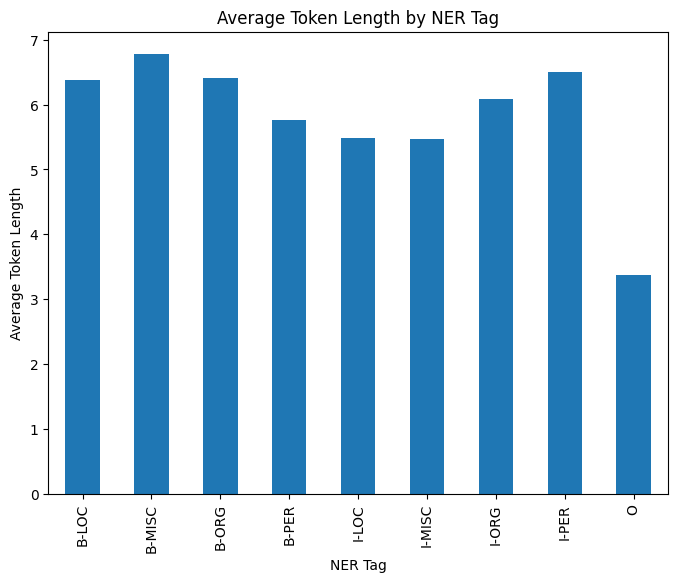

In [12]:
average_token_length = train_df.groupby('NER')['token_length'].mean()
print("Average Token Length by NER Tag:")

for label, avg_length in average_token_length.items():
    print(f"{label}: {avg_length:.2f}")

plt.figure(figsize=(8, 6))
average_token_length.plot(kind='bar')
plt.xlabel("NER Tag")
plt.ylabel("Average Token Length")
plt.title("Average Token Length by NER Tag")
plt.show()


#### Hypothesis 4: Digit Presence
Tokens containing digits are more likely to be labeled as MISC, as they may indicate numerical identifiers, dates, or events.

Proportion of Tokens with Digits by NER Tag:
B-LOC: 0.00
B-MISC: 0.01
B-ORG: 0.00
B-PER: 0.00
I-LOC: 0.00
I-MISC: 0.05
I-ORG: 0.00
I-PER: 0.00
O: 0.16


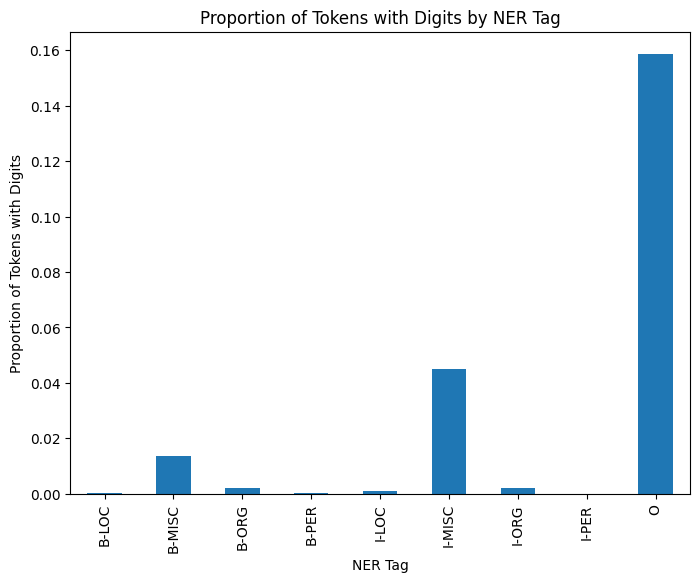

In [13]:
total_counts = train_df['NER'].value_counts()
digit_counts = train_df[train_df['contains_digit']].groupby('NER').size()
digit_ratios = (digit_counts / total_counts).fillna(0)  

print("Proportion of Tokens with Digits by NER Tag:")
for label, ratio in digit_ratios.items():
    print(f"{label}: {ratio:.2f}")

plt.figure(figsize=(8, 6))
digit_ratios.plot(kind='bar')
plt.xlabel("NER Tag")
plt.ylabel("Proportion of Tokens with Digits")
plt.title("Proportion of Tokens with Digits by NER Tag")
plt.show()


#### Hypothesis 5: Chunk Tags
Tokens labeled as part of a noun phrase (NP) are more likely to be named entities, as noun phrases often contain names or identifiers.

Proportion of NP-Chunks by NER Tag:
B-LOC: 0.17
B-MISC: 0.51
B-ORG: 0.32
B-PER: 0.33
I-LOC: 0.94
I-MISC: 0.86
I-ORG: 0.87
I-PER: 0.98
O: 0.28


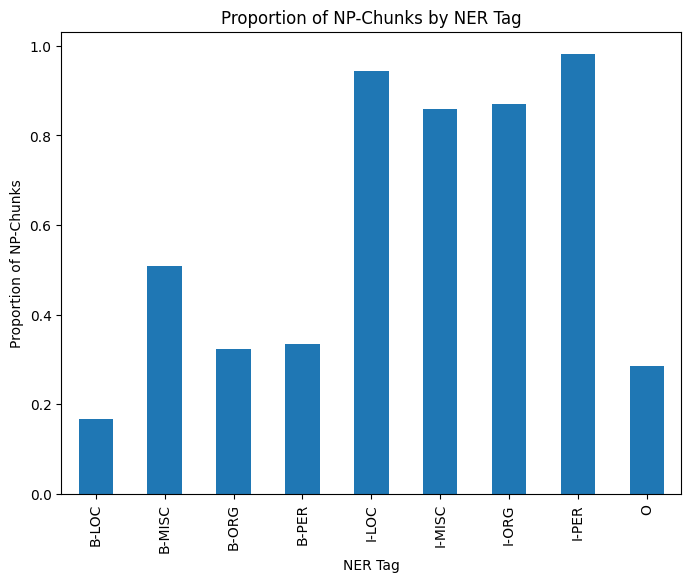

In [14]:
total_counts = train_df['NER'].value_counts()
np_counts = train_df[train_df['chunk_tag'] == 'I-NP'].groupby('NER').size()
np_ratios = (np_counts / total_counts).fillna(0)  

print("Proportion of NP-Chunks by NER Tag:")
for label, ratio in np_ratios.items():
    print(f"{label}: {ratio:.2f}")

plt.figure(figsize=(8, 6))
np_ratios.plot(kind='bar')
plt.xlabel("NER Tag")
plt.ylabel("Proportion of NP-Chunks")
plt.title("Proportion of NP-Chunks by NER Tag")
plt.show()


## 2.3. Evaluation

**Suggestions:**
- Create a sample file with the ground_truth features and labels `sample_gt.conll` and a sample prediction file with the predictions `sample_pred.conll`.
- Create a function functions to calculate different metrics from two files: e.g. precision(), recall(), f-score(), confusion_matrix(). (Note you can use packages, e.g. `sklearn`)

In [15]:
def create_sample_conll_files(df, seed, n_rows=10, n_errors=2, data_folder="../../data/tests/"):
    """
    Helper function to parse randomly sample ~n rows from the train set.
    The function will avoid breaking up entities longer than one token so it might sample > n rows.
    """ 
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    gt_file = os.path.join(data_folder, "sample_gt.conll")
    pred_file = os.path.join(data_folder, "sample_pred.conll")

    sentence_dfs = []
    sentence = []
    for _, row in df.iterrows():
        if row['token'] == "." and row['NER'] == "O":
            if sentence:
                sentence_dfs.append(pd.DataFrame(sentence))
                sentence = []
        else:
            sentence.append(row)
    if sentence:
        sentence_dfs.append(pd.DataFrame(sentence))  

    random.seed(seed)
    sampled_sentences = []
    total_tokens = 0
    while total_tokens < n_rows and sentence_dfs:
        idx = random.choice(range(len(sentence_dfs)))  
        sentence_df = sentence_dfs.pop(idx)            
        sampled_sentences.append(sentence_df)
        total_tokens += len(sentence_df)

    sample_df = pd.concat(sampled_sentences).reset_index(drop=True)
    ground_truth_data = []
    prediction_data = []

    for _, row in sample_df.iterrows():
        token_line = f"{row['token']} {row['pos_tag']} {row['chunk_tag']} {row['NER']}"
        ground_truth_data.append(token_line)
        prediction_data.append(token_line)  

    error_indices = random.sample(range(len(sample_df)), min(n_errors, len(sample_df)))
    for idx in error_indices:
        original_label = sample_df.loc[idx, 'NER']
        possible_labels = [label for label in df['NER'].unique() if label != original_label]
        new_label = random.choice(possible_labels)

        token, pos, chunk, _ = prediction_data[idx].split()
        prediction_data[idx] = f"{token} {pos} {chunk} {new_label}"

    def write_conll_file(data, file_path):
        with open(file_path, 'w') as f:
            for line in data:
                f.write(line + "\n")

    write_conll_file(ground_truth_data, gt_file)
    write_conll_file(prediction_data, pred_file)

    print(f"Ground truth file '{gt_file}' and prediction file '{pred_file}' created with approximately {n_rows} tokens and {n_errors} errors.")

In [16]:
save_dir = "../../data/tests/"   # This folder will be automatically created if not present, if you change the path youll need to change the paths for evaluation too
seed = 42 # Change this to sample a different set
create_sample_conll_files(train_df, seed,  n_rows=100, n_errors=20, data_folder=save_dir)

Ground truth file '../../data/tests/sample_gt.conll' and prediction file '../../data/tests/sample_pred.conll' created with approximately 100 tokens and 20 errors.


In [17]:
def read_labels(file_path):
    """
    Helper function to part a CONLL file and extract only the labels,
    """ 
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            components = line.strip().split()
            if components:  
                labels.append(components[-1])  
    return labels


def evaluate_ner(gt_file, pred_file):
    """
    Function to compare the true and predicted labels of two CONLL formatted files and calculate model metrics.
    """ 
    gt_labels = read_labels(gt_file)
    pred_labels = read_labels(pred_file)

    if len(gt_labels) != len(pred_labels):
        raise ValueError("Ground truth and prediction files must have the same number of labeled tokens.")

    labels = sorted(set(gt_labels + pred_labels)) 
    cm = confusion_matrix(gt_labels, pred_labels, labels=labels)

    precision = precision_score(gt_labels, pred_labels, labels=labels, average='weighted', zero_division=0)
    recall = recall_score(gt_labels, pred_labels, labels=labels, average='weighted', zero_division=0)
    f1 = f1_score(gt_labels, pred_labels, labels=labels, average='weighted', zero_division=0)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

Precision: 0.90
Recall: 0.88
F1-Score: 0.89


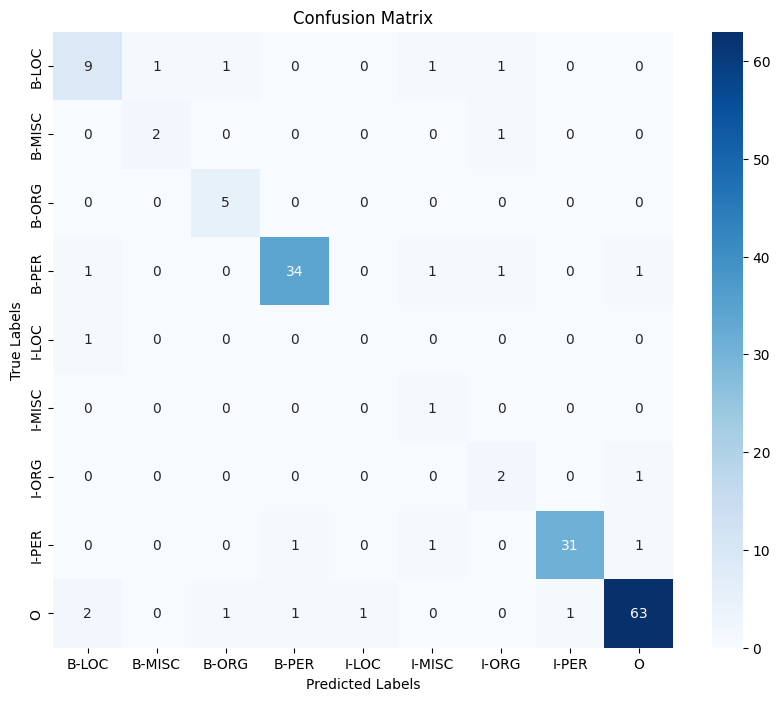

In [18]:
evaluate_ner("../../data/tests/sample_gt.conll", "../../data/tests/sample_pred.conll")  # For example here, if you changed the path in the generation this wont find the files

### Spans Evaluation

In [19]:
def extract_spans_from_file(file_path):
    """
    Extract spans from a BIO-labeled file, considering sentence boundaries.
    Each span is represented as (start_index, end_index, label).
    """
    spans = []
    start = None
    current_label = None
    current_index = 1  # To track token index across sentences

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:  # Empty line denotes a sentence boundary
                if current_label is not None:
                    spans.append((start, current_index - 1, current_label))  # Close span before boundary
                start = None
                current_label = None
                current_index += 1  # Increment index for next sentence start
                continue

            token, pos, chunk, label = line.split()

            if label.startswith("B-"):
                if current_label is not None:
                    spans.append((start, current_index - 1, current_label))  # Close previous span
                start = current_index
                current_label = label[2:]
            elif label.startswith("I-") and current_label == label[2:]:
                # Continue current span
                pass
            else:
                if current_label is not None:
                    spans.append((start, current_index - 1, current_label))  # Close span
                current_label = None
                start = None

            current_index += 1

    if current_label is not None:  # Close any remaining open span at the end of the file
        spans.append((start, current_index - 1, current_label))

    return spans


In [20]:
def span_based_evaluation(gt_file, pred_file, check_spans=False):
    """
    Evaluate precision, recall, F1-score, and plot a confusion matrix at the span level.
    Considers sentence boundaries in the span extraction.
    """

    gt_spans = extract_spans_from_file(gt_file)
    pred_spans = extract_spans_from_file(pred_file)

    label_counts = defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0})

    for span in gt_spans:
        if span in pred_spans:
            label_counts[span[2]]["TP"] += 1  
        else:
            label_counts[span[2]]["FN"] += 1  

    for span in pred_spans:
        if span not in gt_spans:
            label_counts[span[2]]["FP"] += 1  

    all_labels = sorted(set(label for _, _, label in gt_spans + pred_spans))
    precisions, recalls, f1_scores = {}, {}, {}

    for label in all_labels:
        tp = label_counts[label]["TP"]
        fp = label_counts[label]["FP"]
        fn = label_counts[label]["FN"]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions[label] = precision
        recalls[label] = recall
        f1_scores[label] = f1

        print(f"{label} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    # Generate confusion matrix and plot as in the previous code.
    matrix = []
    for true_label in all_labels:
        row = []
        for pred_label in all_labels:
            if true_label == pred_label:
                row.append(label_counts[true_label]["TP"])
            else:
                row.append(label_counts[pred_label]["FP"] if pred_label in label_counts else 0)
        matrix.append(row)

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=all_labels, yticklabels=all_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Span-Level Confusion Matrix")
    plt.show()

    overall_tp = sum(counts["TP"] for counts in label_counts.values())
    overall_fp = sum(counts["FP"] for counts in label_counts.values())
    overall_fn = sum(counts["FN"] for counts in label_counts.values())

    overall_precision = overall_tp / (overall_tp + overall_fp) if (overall_tp + overall_fp) > 0 else 0
    overall_recall = overall_tp / (overall_tp + overall_fn) if (overall_tp + overall_fn) > 0 else 0
    overall_f1 = (2 * overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

    print(f"\nOverall - Precision: {overall_precision:.2f}, Recall: {overall_recall:.2f}, F1-Score: {overall_f1:.2f}")

    if check_spans:
        print(f"GT Spans: {list(gt_spans)[:10]}")
        print(f"Pred Spans: {list(pred_spans)[:10]}")


LOC - Precision: 0.69, Recall: 0.69, F1-Score: 0.69
MISC - Precision: 0.67, Recall: 0.67, F1-Score: 0.67
ORG - Precision: 0.57, Recall: 0.80, F1-Score: 0.67
PER - Precision: 0.86, Recall: 0.82, F1-Score: 0.84


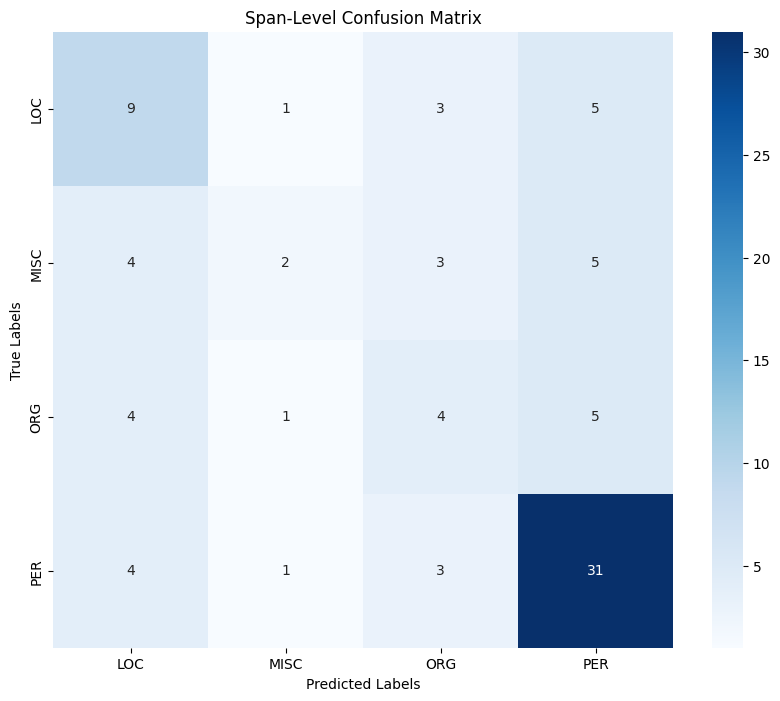


Overall - Precision: 0.78, Recall: 0.78, F1-Score: 0.78
GT Spans: [(1, 2, 'ORG'), (5, 5, 'LOC'), (7, 7, 'LOC'), (10, 10, 'ORG'), (12, 12, 'LOC'), (14, 14, 'LOC'), (16, 16, 'LOC'), (19, 19, 'LOC'), (21, 21, 'LOC'), (23, 24, 'LOC')]
Pred Spans: [(1, 2, 'ORG'), (5, 5, 'LOC'), (9, 9, 'PER'), (10, 10, 'ORG'), (12, 12, 'LOC'), (14, 14, 'LOC'), (16, 16, 'LOC'), (19, 19, 'LOC'), (21, 21, 'LOC'), (24, 24, 'LOC')]


In [21]:
span_based_evaluation("../../data/tests/sample_gt.conll", "../../data/tests/sample_pred.conll", check_spans=True) # Set this to true to visualize spans and compare with file

## 2.4. Train and evaluate basic NERC system
**Suggestions:**
- Train the Logistic regression classifier on your dataset and evaluate the performance on your various metrics.
- Transfer your code to a python file 

In [22]:
def create_classifier(train_features, train_targets, max_iter):
    """
    Function to train a logistic regression model to predict NER tags.
    
    Uses a vectorizer to transform key-value like features into vectors.
    """
    logreg = LogisticRegression(max_iter=max_iter)
    vec = DictVectorizer()
    features_vectorized = vec.fit_transform(train_features)
    model = logreg.fit(features_vectorized, train_targets)
    
    return model, vec

In [23]:
def classify_data(model, vec, inputdata, outputfile, feature_list):
    """Classifies data using only specified features and writes results to a file."""
    features, _ = extract_features_and_labels(inputdata)
    filtered_features = [{k: v for k, v in feature.items() if k in feature_list} for feature in features]
    print(f"Features used: {filtered_features[0]}") # Sanity check
    features_vectorized = vec.transform(filtered_features)
    predictions = model.predict(features_vectorized)
    
    # Using "with" will automatically close the file after it snot used anymore btw
    with open(outputfile, 'w') as outfile:
        counter = 0
        for line in open(inputdata, 'r'):
            components = line.rstrip('\n').split()
            if components:
                # Write token and predicted label, excluding the original true label, that way we can still use our evaluation functions that require two different files
                token, pos_tag, chunk_tag = components[:3]
                outfile.write(f"{token} {pos_tag} {chunk_tag} {predictions[counter]}\n")
                counter += 1

### Train model and Get Predictions

In [24]:
pred_file = "./results/log_results.conll"
feature_list = ['token', 'pos_tag', 'chunk_tag', 'capitalized', 'contains_digit']  # Now we can flexibly choose which features to use
ml_model, vec = create_classifier(train_data, train_targets, max_iter=1000)

classify_data(model=ml_model, vec=vec, inputdata=test_file, outputfile=pred_file, feature_list=feature_list)

/home/andres/Desktop/ma-ml4nlp-labs/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Features used: {'token': 'SOCCER', 'pos_tag': 'NN', 'chunk_tag': 'B-NP', 'capitalized': True, 'contains_digit': False}


### Evaluation

Precision: 0.93
Recall: 0.90
F1-Score: 0.91


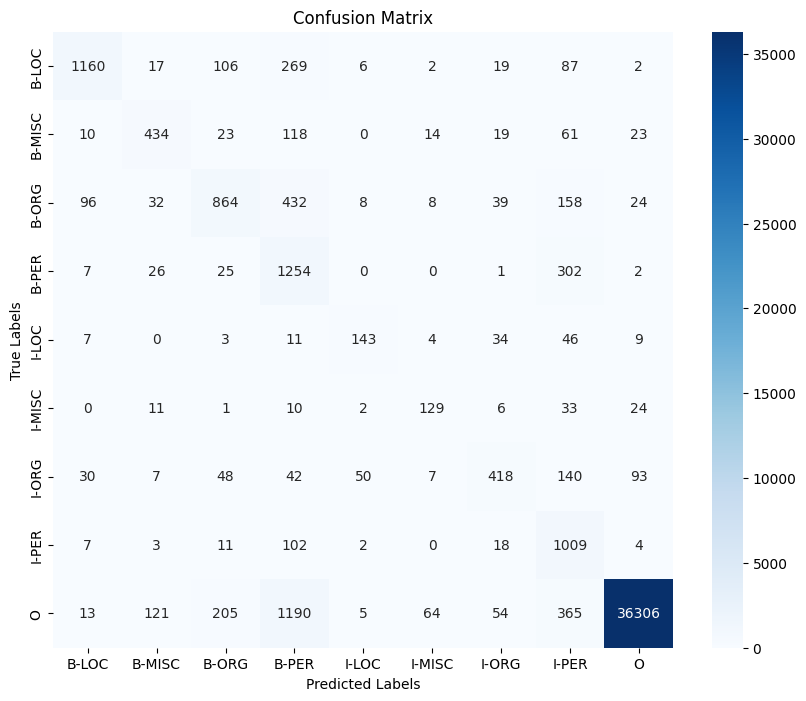

In [25]:
evaluate_ner(test_file, pred_file)

LOC - Precision: 0.03, Recall: 0.02, F1-Score: 0.02
MISC - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
ORG - Precision: 0.02, Recall: 0.02, F1-Score: 0.02
PER - Precision: 0.01, Recall: 0.02, F1-Score: 0.02


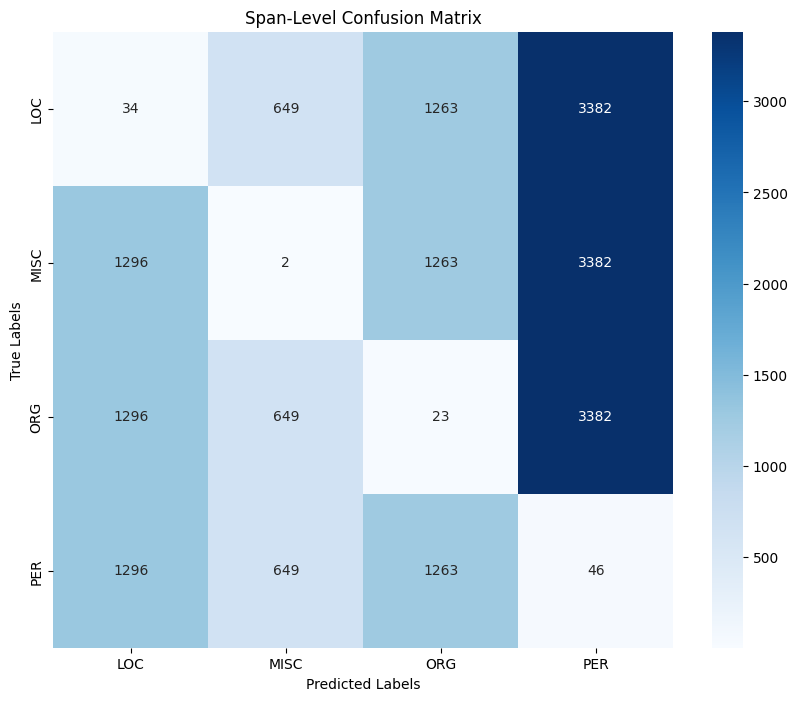


Overall - Precision: 0.02, Recall: 0.02, F1-Score: 0.02
GT Spans: [(3, 3, 'ORG'), (13, 13, 'LOC'), (16, 17, 'MISC'), (19, 20, 'PER'), (28, 28, 'ORG'), (30, 30, 'ORG'), (65, 65, 'ORG'), (67, 67, 'ORG'), (69, 69, 'ORG'), (76, 76, 'ORG')]
Pred Spans: [(1, 1, 'PER'), (3, 3, 'PER'), (4, 4, 'ORG'), (5, 5, 'PER'), (8, 8, 'PER'), (13, 14, 'PER'), (15, 15, 'PER'), (17, 17, 'LOC'), (21, 21, 'LOC'), (27, 28, 'MISC')]


In [26]:
span_based_evaluation(dev_file, pred_file, check_spans=True) # Set this to true to visualize spans and compare with file

### (**optional**) 2.4.2 Convert to a python file:
- This is part is optional for now but will be required for assignment 2, so it is good practice.

Description:
- To convert the code to a python file, you should place all the relevant functions in one `.py` file.
- Add the following lines to the bottom, which ensure that if you call the function from a terminal, the lines within it will be exectued:


In [27]:
def main(argv=None):
    """Takes in an argument list and runs the system"""

    #a very basic way for picking up commandline arguments
    if argv is None:
        argv = sys.argv
        
    #Note 1: argv[0] is the name of the python program if you run your program as: python program1.py arg1 arg2 arg3
    #Note 2: sys.argv is simple, but gets messy if you need it for anything else than basic scenarios with few arguments
    #you'll want to move to something better. e.g. argparse (easy to find online)
    
    
    #you can replace the values for these with paths to the appropriate files for now, e.g. by specifying values in argv
    #argv = ['mypython_program','','','']
    trainingfile = argv[1]
    inputfile = argv[2]
    outputfile = argv[3]
    
    training_features, gold_labels = extract_features_and_labels(trainingfile)
    ml_model, vec = create_classifier(training_features, gold_labels)
    classify_data(ml_model, vec, inputfile, outputfile)

# # uncomment this when using this in a script    
# if __name__ == '__main__':
#     # Code below is executed when this python file is called from terminal
#     main()


In [28]:
# remember that the first element of the list is not used 
# (since this is the `python command when the args are read from sys.argv)
# make sure to complete the rest of the list assigned to args correctly
# args = ['python']
# main(args)